<a href="https://colab.research.google.com/github/jsokolowska/siema-my-z-mechatro/blob/main/SiemaMyZMechatro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup
=====


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import LabelEncoder
from scipy.stats import spearmanr
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = "/content/drive/MyDrive/Data/hackathon/final_train.csv"

df = pd.read_csv(data_path, index_col=0)
df.head()

,Activity,"angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyAccMean,gravity)","angle(tBodyGyroJerkMean,gravityMean)","angle(tBodyGyroMean,gravityMean)",energy-mean(),"fBodyAcc-bandsEnergy()-1,16","fBodyAcc-bandsEnergy()-1,16.1","fBodyAcc-bandsEnergy()-1,16.2","fBodyAcc-bandsEnergy()-1,24","fBodyAcc-bandsEnergy()-1,24.1","fBodyAcc-bandsEnergy()-1,24.2","fBodyAcc-bandsEnergy()-1,8","fBodyAcc-bandsEnergy()-1,8.1","fBodyAcc-bandsEnergy()-1,8.2","fBodyAcc-bandsEnergy()-17,24","fBodyAcc-bandsEnergy()-17,24.1","fBodyAcc-bandsEnergy()-17,24.2","fBodyAcc-bandsEnergy()-17,32","fBodyAcc-bandsEnergy()-17,32.1","fBodyAcc-bandsEnergy()-17,32.2","fBodyAcc-bandsEnergy()-25,32","fBodyAcc-bandsEnergy()-25,32.1","fBodyAcc-bandsEnergy()-25,32.2","fBodyAcc-bandsEnergy()-25,48","fBodyAcc-bandsEnergy()-25,48.1","fBodyAcc-bandsEnergy()-25,48.2","fBodyAcc-bandsEnergy()-33,40","fBodyAcc-bandsEnergy()-33,40.1","fBodyAcc-bandsEnergy()-33,40.2","fBodyAcc-bandsEnergy()-33,48","fBodyAcc-bandsEnergy()-33,48.1","fBodyAcc-bandsEnergy()-33,48.2","fBodyAcc-bandsEnergy()-41,48","fBodyAcc-bandsEnergy()-41,48.1","fBodyAcc-bandsEnergy()-41,48.2","fBodyAcc-bandsEnergy()-49,56",...,"tGravityAcc-correlation()-Y,Z",tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAccMag-arCoeff()1,tGravityAccMag-arCoeff()2,tGravityAccMag-arCoeff()3,tGravityAccMag-arCoeff()4,tGravityAccMag-energy(),tGravityAccMag-entropy(),tGravityAccMag-iqr(),tGravityAccMag-mad(),tGravityAccMag-max(),tGravityAccMag-mean(),tGravityAccMag-min(),tGravityAccMag-sma(),tGravityAccMag-std(),void()
0,STANDING,-1.574191,-0.805700,-2.453831,-1.861714,0.115517,-2.023369,3.125860,-9.474436,3.622600,6.137246,2.503062,5.776680,3.242765,-1.352936,-1.537732,2.828395,8.603183,-2.228620,5.355308,3.987723,1.880228,1.384042,-2.163548,0.483175,2.942713,5.837147,2.957527,-1.770934,-5.580564,13.725027,1.724643,-0.519345,4.233416,0.953127,0.807692,2.624547,-3.005993,3.329588,2.866778,...,2.988204,1.531084,-3.422785,1.852121,8.394366,3.246233,0.937300,4.725389,-1.578871,-0.442374,4.068593,4.705346,7.195449,-6.003664,0.607255,-1.499318,2.246320,2.861260,3.815614,-2.151051,-3.122438,-0.336110,6.357369,3.741996,1.394575,4.017211,2.481302,5.774536,1.754626,1.180533,5.049130,3.272281,5.103018,-0.823302,3.063681,-0.928676,-1.007695,3.094236,1.669987,1.0
1,WALKING_UPSTAIRS,-1.568669,-0.612620,-2.488338,-1.751117,0.218134,0.280294,7.953403,-0.679894,2.512880,5.740178,2.803435,5.484726,2.102368,-1.355854,-1.416568,2.527046,8.046001,-1.986672,5.284168,3.598328,1.892567,1.417711,-2.027475,0.436458,2.908602,5.819734,2.551773,-1.756530,-5.503246,13.251491,1.714753,-0.552312,3.566532,0.922455,0.726768,2.081277,-3.081267,3.140684,2.684137,...,2.859864,1.585023,-3.387872,1.698743,8.112279,1.926083,2.348895,4.719540,-1.521161,-0.463599,4.063648,4.730261,7.221653,-5.789276,0.417687,-0.703212,2.488702,2.391994,5.884982,-2.187197,-3.306482,-0.814718,6.077734,3.720622,1.202847,4.050714,4.539801,4.618405,1.727481,0.220730,4.565443,4.440779,3.288399,-2.689605,1.705341,-0.822617,-0.572410,-2.187890,-0.544652,2.0
2,LAYING,-1.548333,-0.139628,-2.380889,-1.915239,0.067613,-0.887342,6.007361,-11.906904,3.621984,6.158630,2.495276,5.776843,3.314383,-1.352860,-1.537483,2.845718,8.618923,-2.232214,5.378175,3.998898,1.879989,1.372814,-2.169002,0.485317,2.957325,5.841023,2.974139,-1.775050,-5.600164,13.743085,1.726239,-0.505341,4.256780,0.957134,0.831419,2.640759,-2.999393,3.359696,2.868557,...,3.717038,1.851578,-4.07074

In [ ]:
X = df.drop("Activity", axis=1)
y = df["Activity"]

Analiza danych 
===


Znaczenie kolumn na pierwszy rzut oka nie jest jasne, jednak chwila przeszukiwania internetu i można znaleźć dobre wyjaśnienie tych danych np. https://github.com/KarthikMurugadoss1804/Human-Activity-Recognition.

Jednak pewne atrybuty od początku wzbudzają wątpliwości, np. atrybut void() wydaje się być zupełnie przypadkowo dodany. Pozostałe atrybuty wydają sie sensownie dobrane. 

Można też zauważyć pewną powtarzalność - są "sparowane" atrybuty zaczynające się od t lub od f, które zgodnie z podlinkowanych artykułek powstały po zastosowaniu transformaty fouriera dla atrybutów zaczynających się od "t". To potencjalna redundacja, którą prawdopodobnie można bezstratnie usunąć. 

In [ ]:
df["Activity"].unique()

array(['STANDING', 'WALKING_UPSTAIRS', 'LAYING', 'WALKING', 'SITTING',
       'WALKING_DOWNSTAIRS'], dtype=object)

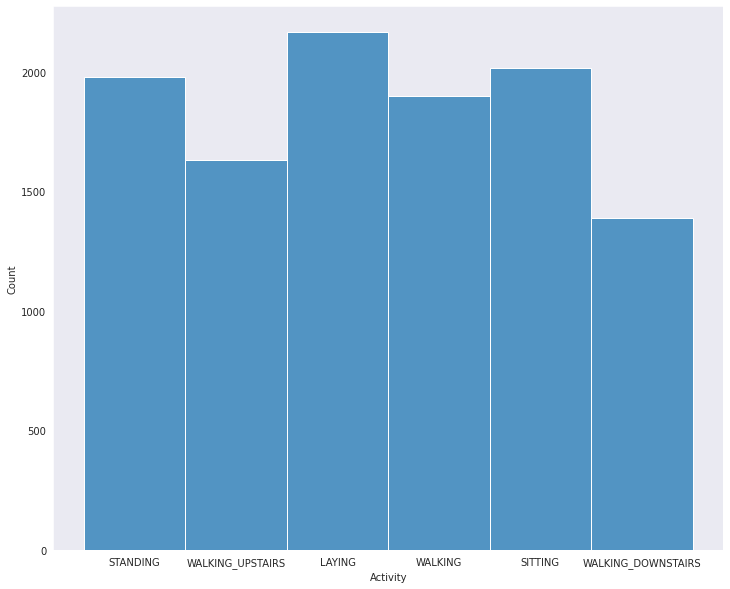

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
sns.set_style("dark")
sns.histplot(df["Activity"], edgecolor='white')

Klasy są w miare równomniernie rozłożone, więc nie powinny powodować problemów podczas klasyfikacji. 

Z wykresu wynika, że liczebności klas w naszym zbiorze testowym mają te same rzędy wielkości i ich rozkład jest w miarę równoważny. W związku z tym do oceny jakości modelu użyjemy prostej metryki - dokładności (ang. accuracy), obliczanej przez użycie metody score() na modelu z sklearn.

In [ ]:
# sprawdzenie jak wiele wartości jest pustych
df.isnull().sum()

Activity                                 0
angle(X,gravityMean)                    57
angle(Y,gravityMean)                    68
angle(Z,gravityMean)                    60
angle(tBodyAccJerkMean),gravityMean)    52
                                        ..
tGravityAccMag-mean()                   65
tGravityAccMag-min()                    66
tGravityAccMag-sma()                    57
tGravityAccMag-std()                    46
void()                                  65
Length: 572, dtype: int64

In [ ]:
df.isnull().sum(axis=1).describe()

count    11086.000000
mean         2.943893
std          8.422681
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         40.000000
dtype: float64

Największa ilość brakujących danych w wierszu wynosi 40. Dyspoując ponad 500 atrybutami zdecydowaliśmy się na wypełnienie brakujących wartości średnią z wartości kolumny danego atrybutu. Dzięki temu nie tracimy danych treningowych, które są bardzo istotne, ponieważ przy 500 atrybutach potrzeba duzej ilości danych aby zbadać wszystkie kombinacje wartości.

In [ ]:
# filling empty spaces with mean
df = df.fillna(df.mean())

Dane zostały zebrane z 30 osób, na których dokonywane były różne pomiary w trakcie wykonywania różnych czynności. Dane o tym, od której osoby otrzymany jest dany pomiar są zapisane w kolumnie “subject”. Jeśli chcielibyśmy zastosować model do predykcji na podstawie pomiarów otrzymanych od osoby, która nie była w grupie testowej to informacje nauczone na podstawie kolumny “subject”  są w najlepszym przypadku bezużyteczne, a w najgorszym powodują przeuczenie do danych testowych. W związku z tym na samym początku ta kolumna zostanie usunięta. Może to spowodować pogorszenie wyników na zbiorze testowym, bo on również zawiera dane od osób z grupy testowej, ale takie podejście zdecydowanie poprawia możliwości generalizacji modelu.

In [ ]:
df = df.drop(columns='subject')

Redukcja wymiarowości 
=====
Redukcja wymiarowości poprzez selekcję atrybutów

Z testów wstępnych wynika, że bardzo dobre wyniki otrzymuje prosty liniowy model regresji logistycznej (Podejrzewamy, że wynika to z tego, że w danych testowych występuje wiele “sztucznych” wysokopoziomowych atrybutów, które zawierają informacje o niektórych nieliniowych związkach z podstawowymi atrybutami pomiarów). W związku z tym do wyboru mało informatywnych atrybutów użyjemy korelacji spearmana (ponieważ klasy mają wartości kategoryczne, dla których kodowanie liczbowe nie miałoby sensu), która wykrywa tylko liniowe związki - co w przypadku naszego modelu w zupełności wystarczy.

In [ ]:
# sprawdzenie korelacji atrybutów z atrybutem klasyfikacji
res = []
df_no_a = df.drop("Activity", axis=1)
labels = df["Activity"]

for f in df_no_a.columns:
  res.append(df[f].corr(labels, method='spearman'))

In [ ]:
col = df_no_a .columns.to_list()

correl = pd.DataFrame(res, index = col)
weak_f = correl[abs(correl[0]) < 0.3]

len(weak_f)

106

In [ ]:
sort = correl.sort_values(by=0)
px.line(sort, y=sort[0], x=sort.index, title='Korelacja spearmana atrybutów z klasa wynikową')

Mamy w danych sporo atrybutów o niskiej korelacji z atrybutem klasyfikacji - prawdopodobnie bez wielkich strat dla dokładności modelu można je usunąć. Wśród nich jest też atrybut wcześniej wyróżniony jako podejrzany - "void()".


Ponad to podczas analizy danych zauważyliśmy występowanie atrybutów, które powstały w skutek zastosowania transformaty Fouriera na innych atrybutach. Atrybuty takie mogą wprowadzać niepotrzebną redundancję danych. Sprawdzamy czy atrybuty te są skorelowane z ich odpowiednikami w dziedzinie czasu - jeśli korelacja jest silniejsza niż pewien ustawiony próg usuwamy je z modelu.

In [ ]:
# sprawdzenie korelacji odpowiadających sobie atrybutów f i t - podejrzewamy, że mogą wprowadzać redundancję
def inv_fourier(df, fourier_labels):
  inv_fourier_labels = [label.replace('f', 't', 1) for label in fourier_labels]
  return df.filter(items=inv_fourier_labels)

def fourier_correlation(df, inv_fourier_labels):
  results = pd.DataFrame(columns=['label', 'value'])
  for label in inv_fourier_labels:
    new_row = {'label': label[1:], 'value': df[label].corr(df[label.replace('t', 'f', 1)])}
    results = results.append(new_row, ignore_index=True)
  return results

fourier_labels = df.filter(regex='^f').columns
inv_fourier_labels = inv_fourier(df, fourier_labels)

correlation = fourier_correlation(df, inv_fourier_labels)

def fourier_features(df, correlation, threshold=0.5):
  features = []
  for index, row in correlation.iterrows():
    if abs(float(row['value']) > threshold):
      features.append('f'+row['label'])

  return features

def filter_correlating_fourier(df, correlation, threshold=0.5):
  features = fourier_features(df, correlation, threshold)
  return df.drop(columns=features, errors='ignore')

  # filtered = df.copy()
  # for index, row in correlation.iterrows():
  #   if abs(float(row['value']) > threshold):
  #     filtered = filtered.drop(columns=['f'+row['label']], errors='ignore')

  # return filtered

no_fourier = filter_correlating_fourier(df, correlation)
print(no_fourier.shape, df.shape)


(11086, 523) (11086, 571)


Po teście korelacji atrybutów Fouriera usunięte zostało 48 atrybutów.

Normalizujemy dane redukując średnią atrybutu do 0 oraz odchylenie standardowe do 1.

In [ ]:
# normalizacja
import sklearn.preprocessing as preprocessing
X = df.drop('Activity', axis='columns')
X = X.fillna(X.mean())

def normalize(df):
    cols = df.columns
    x = df.values #returns a numpy array
    scaler = preprocessing.StandardScaler()
    x_scaled = scaler.fit_transform(x)
    return pd.DataFrame(x_scaled, columns=cols)

X = normalize(X)

Szkolenie modeli
====
Szkolimy model regresji logistycznej dla 3 zbiorów atrybutów - pełnego, zredukowanego o słabo skorelowane z klasą wynikową oraz zredukowanego dwukrotnie: o mało skorelowane z klasą wynikową oraz redundantne atrybuty Fouriera.

In [ ]:
# przykładowa klasyfikacja z wykorzystaniem wszystkich atrybutów
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

model_lr = LogisticRegression(random_state=69).fit(X_train, y_train)
best_score = model_lr.score(X_test, y_test)
best_score

0.9813589897775106

In [ ]:
# zbiór atrybutów zredukowany o te nisko skorelowane z atrybutem docelowym
weak_f = correl[abs(correl[0]) < 0.5]

X_train_reduced = X_train.drop(weak_f.index, axis=1)
print(X_train.shape, X_train_reduced.shape, weak_f.shape) #sanity check

X_test_reduced = X_test.drop(weak_f.index, axis=1)
print(X_test.shape, X_test_reduced.shape, weak_f.shape) #sanity check

model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
model_lr.score(X_test_reduced, y_test) # 0.969 czyli lekki, ale akceptowalny spadek

(7760, 570) (7760, 418) (152, 1)
(3326, 570) (3326, 418) (152, 1)


0.9705351773902585

In [ ]:
# dodatkowa redukcja wewnętrznie skorelowaych atrybutów fouriera
X_train_reduced = filter_correlating_fourier(X_train_reduced, correlation)
print(X_train.shape, X_train_reduced.shape) #sanity check

X_test_reduced = filter_correlating_fourier(X_test_reduced,correlation )
print(X_test.shape, X_test_reduced.shape) #sanity check

model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
model_lr.score(X_test_reduced, y_test) #0.966 czyli mały, zupełnie okej spadek

(7760, 570) (7760, 370)
(3326, 570) (3326, 370)


0.9687312086590499

Strojenie hiperparametrów redukcji atrybutów
====


Badamy jak odrzucanie atrybutów malo skorelowanych z atrybutem wynikowym wpływa na dokładność modelu

In [ ]:
#strojenie hiperparametru progu usuwania atrybutów małoinformatywnych
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
res = []
num = []

for th in thresholds:

  weak_f = correl[abs(correl[0]) < th]
  num.append(len(weak_f.index ))

  # dropping according to threshold
  X_train_reduced = X_train.drop(weak_f.index, axis=1)
  X_test_reduced = X_test.drop(weak_f.index, axis=1)

  #dropping correlated fourier attibutes
  X_test_reduced = filter_correlating_fourier(X_test_reduced, correlation)
  X_train_reduced = filter_correlating_fourier(X_train_reduced, correlation)

  model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
  score = model_lr.score(X_test_reduced, y_test)

  res.append(score)

In [ ]:
for i in range (len(res)):
  print(f'Score for threshold {thresholds[i]} - {res[i]}, dropeed {num[i]} features. Difference to best score: {best_score- res[i]}')

Score for threshold 0.3 - 0.9813589897775106, dropeed 106 features. Difference to best score: 0.0
Score for threshold 0.4 - 0.9768490679494889, dropeed 138 features. Difference to best score: 0.004509921828021679
Score for threshold 0.5 - 0.9687312086590499, dropeed 152 features. Difference to best score: 0.012627781118460635
Score for threshold 0.6 - 0.9236319903788335, dropeed 175 features. Difference to best score: 0.05772699939867709
Score for threshold 0.7 - 0.9116055321707757, dropeed 300 features. Difference to best score: 0.0697534576067349


Decydujemy się na próg 0.4 - pozwala zredukować wymiarowość o 139 atrybutów, a dokładność klasyfikacji spada o niecały punkt procentowy

In [ ]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
res = []
num = []
base = len(X_train.columns)

for th in thresholds:

  weak_f = correl[abs(correl[0]) < 0.4]

  # dropping according to threshold
  X_train_reduced = X_train.drop(weak_f.index, axis=1)
  X_test_reduced = X_test.drop(weak_f.index, axis=1)

  #dropping correlated fourier attibutes
  X_test_reduced = filter_correlating_fourier(X_test_reduced, correlation, th)
  X_train_reduced = filter_correlating_fourier(X_train_reduced, correlation, th)

  model_lr = LogisticRegression(random_state=69).fit(X_train_reduced, y_train)
  score = model_lr.score(X_test_reduced, y_test)

  num.append(base - len(X_train_reduced.columns))
  res.append(score)

In [ ]:
for i in range (len(res)):
  print(f'Score for threshold {thresholds[i]} - {res[i]}, dropeed {num[i]} features. Difference to best score: {best_score- res[i]}')

Score for threshold 0.3 - 0.9768490679494889, dropeed 186 features. Difference to best score: 0.004509921828021679
Score for threshold 0.4 - 0.9768490679494889, dropeed 186 features. Difference to best score: 0.004509921828021679
Score for threshold 0.5 - 0.9768490679494889, dropeed 186 features. Difference to best score: 0.004509921828021679
Score for threshold 0.6 - 0.9765484064942874, dropeed 184 features. Difference to best score: 0.0048105832832231465
Score for threshold 0.7 - 0.9765484064942874, dropeed 179 features. Difference to best score: 0.0048105832832231465


Zmiany progu nie powodują zmiany ilości wyrzucanych atrybutów, dlatego dla redundantnych atrybutów fouriera pozostaniemy przy progu domyślnym - 0.5

Najlepsze parametry modelu znalezione w procesie dopasowywania hiperparametrów

In [ ]:
LogisticRegression(tol = 1e-06, solver= 'lbfgs', penalty='l2', multi_class= 'multinomial', max_iter= 300, C= 1.0)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=300,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=1e-06, verbose=0,
                   warm_start=False)

Interpretacja wyników
====


Dużą zaletą modelu regresji logistycznej jest łatwa interpretacja wyników modelu. Na podstawie wag poszczególnych atrybutów można ocenić jak istotny jest dany parametr dla predykcji modelu. Jako że model regresji logistycznej dla problemu klasyfikacji niebinarnej tworzy tyle klasyfikatorów ile jest klas to wagi atrybutów są różne dla każdej etykiety. Można więc ocenić które metryki niosą ze sobą najwięcej informacji potrzebnych do klasyfikacji każdej z danej przewidywanej czynności.

In [ ]:
from plotly.subplots import make_subplots


def most_important_features(X, model_lr, top_n=5):
    
    feature_importance = {}

    for i, aclass in enumerate(model_lr.classes_):
        importance = abs(model_lr.coef_[i])

        importance_df = pd.DataFrame(importance, columns=['Importance'])
        importance_df = importance_df.sort_values(by='Importance',ascending=False)
        top = importance_df[:top_n]
        top.index.name = 'Feature'
        top = top.reset_index()
        top['Feature'] = top['Feature'].map(lambda i: X.columns[i])
        #best_features = {X.columns[col]:importance for col, importance in top.itertuples()}
        feature_importance[aclass] = top
        
    return feature_importance


def plot_most_important_features(feature_importance):
    plt_titles = list(feature_importance.keys())
    length = len(feature_importance)
    
    fig = make_subplots(
        rows=len(feature_importance),
        cols=1,
        subplot_titles=plt_titles,
    )
    
    for i,top in enumerate(feature_importance.values()):
        f = px.bar(top, x='Feature', y='Importance')
        fig.add_trace(f.data[0], row = i + 1, col = 1)
    fig.update_layout(height=length * 350, width=900)
    fig.show()

feature_importance = most_important_features(X, model_lr, top_n=8)
plot_most_important_features(feature_importance)

[[]]

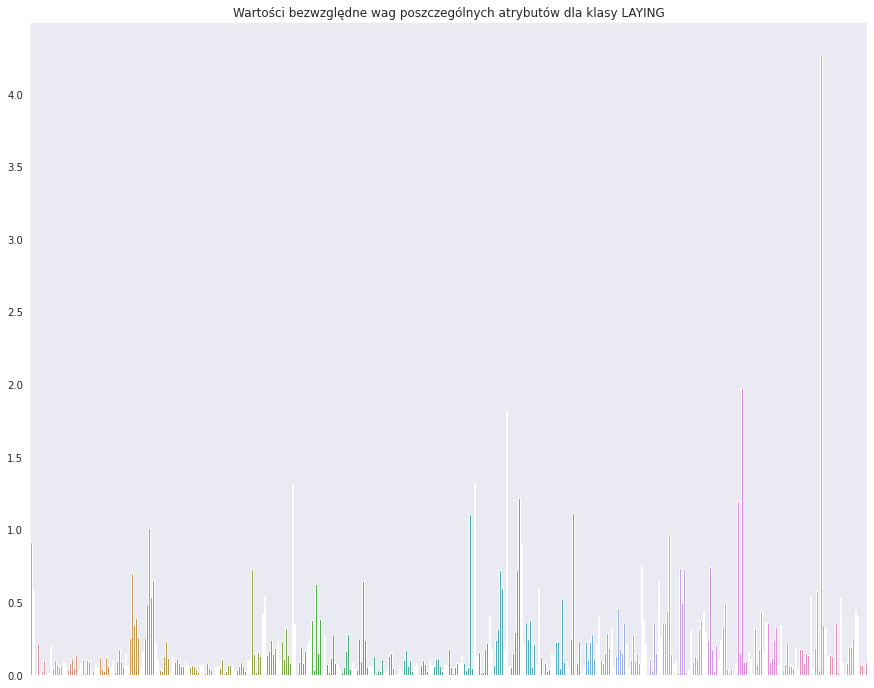

In [ ]:
importance = abs(model_lr.coef_[0])
figure = plt.figure(figsize=(15, 12))
plot = sns.barplot([x for x in range(len(importance))], importance)
plot.set_title('Wartości bezwzględne wag poszczególnych atrybutów dla klasy LAYING')
plot.set(xticklabels=[])

Wersja finalna
====

In [1]:
class Model:
  def __init__(self, model, scaler):
    self.model = model
    self.scaler = scaler
    self.dropped_features = ['angle(X,gravityMean)','angle(tBodyAccJerkMean),gravityMean)',
 'angle(tBodyAccMean,gravity)',
 'angle(tBodyGyroJerkMean,gravityMean)',
 'angle(tBodyGyroMean,gravityMean)',
 'energy-mean()',
 'fBodyAcc-energy()-X',
 'fBodyAcc-entropy()-X',
 'fBodyAcc-entropy()-Y',
 'fBodyAcc-entropy()-Z',
 'fBodyAcc-iqr()-X',
 'fBodyAcc-iqr()-Y',
 'fBodyAcc-iqr()-Z',
 'fBodyAcc-kurtosis()-X',
 'fBodyAcc-kurtosis()-Y',
 'fBodyAcc-kurtosis()-Z',
 'fBodyAcc-mad()-X',
 'fBodyAcc-mad()-Z',
 'fBodyAcc-main()-X',
 'fBodyAcc-main()-Z',
 'fBodyAcc-max()-X',
 'fBodyAcc-maxInds-X',
 'fBodyAcc-maxInds-Y',
 'fBodyAcc-maxInds-Z',
 'fBodyAcc-meanFreq()-X',
 'fBodyAcc-min()-X',
 'fBodyAcc-skewness()-X',
 'fBodyAcc-skewness()-Y',
 'fBodyAcc-skewness()-Z',
 'fBodyAcc-sma()',
 'fBodyAcc-std()-X',
 'fBodyAcc-std()-Y',
 'fBodyAcc-std()-Z',
 'fBodyAccJerk-energy()-Y',
 'fBodyAccJerk-entropy()-X',
 'fBodyAccJerk-mad()-Z',
 'fBodyAccJerk-max()-Z',
 'fBodyAccJerk-maxInds-Y',
 'fBodyAccJerk-maxInds-Z',
 'fBodyAccJerk-min()-X',
 'fBodyAccJerk-min()-Y',
 'fBodyAccJerk-sma()',
 'fBodyAccJerk-std()-X',
 'fBodyAccJerk-std()-Z',
 'fBodyAccMag-energy()',
 'fBodyAccMag-entropy()',
 'fBodyAccMag-iqr()',
 'fBodyAccMag-kurtosis()',
 'fBodyAccMag-mad()',
 'fBodyAccMag-maxInds',
 'fBodyAccMag-meanFreq()',
 'fBodyAccMag-min()',
 'fBodyAccMag-skewness()',
 'fBodyAccMag-sma()',
 'fBodyAccMag-std()',
 'fBodyBodyAccJerkMag-kurtosis()',
 'fBodyBodyAccJerkMag-maxInds',
 'fBodyBodyAccJerkMag-meanFreq()',
 'fBodyBodyAccJerkMag-skewness()',
 'fBodyBodyGyroJerkMag-kurtosis()',
 'fBodyBodyGyroJerkMag-maxInds',
 'fBodyBodyGyroJerkMag-meanFreq()',
 'fBodyBodyGyroJerkMag-skewness()',
 'fBodyBodyGyroMag-kurtosis()',
 'fBodyBodyGyroMag-maxInds',
 'fBodyBodyGyroMag-meanFreq()',
 'fBodyBodyGyroMag-skewness()',
 'fBodyGyro-energy()-X',
 'fBodyGyro-energy()-Y',
 'fBodyGyro-energy()-Z',
 'fBodyGyro-entropy()-X',
 'fBodyGyro-entropy()-Y',
 'fBodyGyro-iqr()-X',
 'fBodyGyro-iqr()-Z',
 'fBodyGyro-kurtosis()-X',
 'fBodyGyro-kurtosis()-Y',
 'fBodyGyro-kurtosis()-Z',
 'fBodyGyro-mad()-X',
 'fBodyGyro-mad()-Y',
 'fBodyGyro-max()-X',
 'fBodyGyro-max()-Y',
 'fBodyGyro-max()-Z',
 'fBodyGyro-maxInds-X',
 'fBodyGyro-maxInds-Z',
 'fBodyGyro-meanFreq()-Y',
 'fBodyGyro-meanFreq()-Z',
 'fBodyGyro-min()-X',
 'fBodyGyro-skewness()-X',
 'fBodyGyro-skewness()-Y',
 'fBodyGyro-skewness()-Z',
 'fBodyGyro-sma()',
 'fBodyGyro-std()-X',
 'fBodyGyro-std()-Y',
 'fBodyGyro-std()-Z',
 'shadow-gravity-angle()',
 'subject',
 'tBodyAcc-arCoeff()-X,2',
 'tBodyAcc-arCoeff()-X,3',
 'tBodyAcc-arCoeff()-X,4',
 'tBodyAcc-arCoeff()-Y,2',
 'tBodyAcc-arCoeff()-Y,3',
 'tBodyAcc-arCoeff()-Y,4',
 'tBodyAcc-arCoeff()-Z,3',
 'tBodyAcc-arCoeff()-Z,4',
 'tBodyAcc-correlation()-X,Y',
 'tBodyAcc-correlation()-X,Z',
 'tBodyAcc-correlation()-Y,Z',
 'tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAccJerk-arCoeff()-X,2',
 'tBodyAccJerk-arCoeff()-X,3',
 'tBodyAccJerk-arCoeff()-X,4',
 'tBodyAccJerk-arCoeff()-Y,2',
 'tBodyAccJerk-arCoeff()-Y,3',
 'tBodyAccJerk-arCoeff()-Y,4',
 'tBodyAccJerk-arCoeff()-Z,2',
 'tBodyAccJerk-arCoeff()-Z,3',
 'tBodyAccJerk-arCoeff()-Z,4',
 'tBodyAccJerk-correlation()-X,Y',
 'tBodyAccJerk-correlation()-X,Z',
 'tBodyAccJerk-correlation()-Y,Z',
 'tBodyAccJerk-mean()-X',
 'tBodyAccJerk-mean()-Y',
 'tBodyAccJerk-mean()-Z',
 'tBodyAccJerkMag-arCoeff()3',
 'tBodyAccJerkMag-arCoeff()4',
 'tBodyAccMag-arCoeff()3',
 'tBodyAccMag-arCoeff()4',
 'tBodyGyro-arCoeff()-X,2',
 'tBodyGyro-arCoeff()-X,3',
 'tBodyGyro-arCoeff()-Y,1',
 'tBodyGyro-arCoeff()-Y,3',
 'tBodyGyro-arCoeff()-Y,4',
 'tBodyGyro-arCoeff()-Z,3',
 'tBodyGyro-arCoeff()-Z,4',
 'tBodyGyro-correlation()-X,Y',
 'tBodyGyro-correlation()-X,Z',
 'tBodyGyro-correlation()-Y,Z',
 'tBodyGyro-low()-X',
 'tBodyGyro-low()-Y',
 'tBodyGyro-low()-Z',
 'tBodyGyro-mean()-X',
 'tBodyGyro-mean()-Y',
 'tBodyGyro-mean()-Z',
 'tBodyGyroJerk-arCoeff()-X,2',
 'tBodyGyroJerk-arCoeff()-X,3',
 'tBodyGyroJerk-arCoeff()-X,4',
 'tBodyGyroJerk-arCoeff()-Y,2',
 'tBodyGyroJerk-arCoeff()-Y,3',
 'tBodyGyroJerk-arCoeff()-Y,4',
 'tBodyGyroJerk-arCoeff()-Z,2',
 'tBodyGyroJerk-arCoeff()-Z,3',
 'tBodyGyroJerk-arCoeff()-Z,4',
 'tBodyGyroJerk-correlation()-X,Y',
 'tBodyGyroJerk-correlation()-X,Z',
 'tBodyGyroJerk-correlation()-Y,Z',
 'tBodyGyroJerk-mean()-X',
 'tBodyGyroJerk-mean()-Y',
 'tBodyGyroJerk-mean()-Z',
 'tBodyGyroJerkMag-arCoeff()1',
 'tBodyGyroJerkMag-arCoeff()2',
 'tBodyGyroJerkMag-arCoeff()3',
 'tBodyGyroJerkMag-arCoeff()4',
 'tBodyGyroMag-arCoeff()1',
 'tBodyGyroMag-arCoeff()2',
 'tBodyGyroMag-arCoeff()3',
 'tBodyGyroMag-arCoeff()4',
 'tBodyGyroMag-entropy()',
 'tGravityAcc-arCoeff()-X,1',
 'tGravityAcc-arCoeff()-X,2',
 'tGravityAcc-arCoeff()-X,3',
 'tGravityAcc-arCoeff()-X,4',
 'tGravityAcc-arCoeff()-Y,1',
 'tGravityAcc-arCoeff()-Y,2',
 'tGravityAcc-arCoeff()-Y,3',
 'tGravityAcc-arCoeff()-Y,4',
 'tGravityAcc-arCoeff()-Z,1',
 'tGravityAcc-arCoeff()-Z,2',
 'tGravityAcc-arCoeff()-Z,3',
 'tGravityAcc-arCoeff()-Z,4',
 'tGravityAcc-correlation()-X,Y',
 'tGravityAcc-correlation()-X,Z',
 'tGravityAcc-correlation()-Y,Z',
 'tGravityAcc-energy()-X',
 'tGravityAcc-energy()-Z',
 'tGravityAcc-entropy()-X',
 'tGravityAcc-entropy()-Y',
 'tGravityAcc-entropy()-Z',
 'tGravityAcc-iqr()-X',
 'tGravityAcc-mad()-X',
 'tGravityAcc-max()-X',
 'tGravityAcc-mean()-X',
 'tGravityAcc-min()-X',
 'tGravityAcc-sma()',
 'tGravityAcc-std()-X',
 'tGravityAccMag-arCoeff()3',
 'tGravityAccMag-arCoeff()4',
 'tGravityAccMag-mad()',
 'tGravityAccMag-sma()',
 'void()']
  def preprocess (self, x_test):
    print("A", x_test.shape)
    x_red = x_test.fillna(x_test.mean())
    print("A")
    scaled = self.scaler.transform(x_red)
    print("A", x_red.shape)
    x_red = pd.DataFrame(data = scaled, columns= x_red.columns)
    print("A")
    x_red = x_red.drop(self.dropped_features, axis=1)
    print("A")
    return x_red
  def predict(self, x_test):
    return self.model.predict(x_test)

In [2]:
df = pd.read_csv(data_path, index_col=0)

import sklearn.preprocessing as preprocessing


X = df.drop('Activity', axis='columns')
just_x  = X
labels = df["Activity"]

X = X.fillna(X.mean())
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=69 )

cols = X_train.columns
X = X_train.values # returns a numpy array
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(x_scaled, columns=cols)
x_train = X.drop(dropped_features, axis=1)


clf = LogisticRegression(tol = 1e-06, solver= 'lbfgs', penalty='l2', multi_class= 'multinomial', max_iter= 300, C= 1.0)
clf.fit(x_train, y_train)

model = Model(clf, min_max_scaler)

X = model.preprocess(just_x)

pred = model.predict(X)
np.mean(pred==df.Activity)

NameError: ignored

In [ ]:
import pickle
with open("model.pkl", "wb+") as f:
  pickle.dump(model, f)